In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [ ]:
torch.manual_seed(1)
np.random.seed(1)

In [ ]:
expt_data_temp_train = np.array([154.196,	158.403,	162.597, 170.691,	174.688,	178.569, 187.356,	192.663, 194.982])
expt_data_temp_train = expt_data_temp_train.reshape(-1,1)
expt_data_temp_val = np.array([166.704, 182.333, 195.831])
expt_data_temp_val = expt_data_temp_val.reshape(-1,1)
expt_data_press_train = np.array([0.015092,	0.025864,	0.042943,	0.107718,	0.162919,	0.23986, 0.54286,	0.85774,	1.0394	])
expt_data_press_val = np.array([0.069141, 0.343771, 1.1136])

In [ ]:
def r2(pred, actual):
  sum_residual = np.sum((pred - actual)**2)
  total_sum_square = np.sum((actual - np.mean(actual))**2)
  coeff_of_det = 1 - (sum_residual / total_sum_square)
  return coeff_of_det

In [ ]:
lin_reg = LinearRegression().fit(expt_data_temp_train, expt_data_press_train)

In [ ]:
lin_reg_press_train_pred = lin_reg.predict(expt_data_temp_train)
lin_reg_press_val_pred = lin_reg.predict(expt_data_temp_val)

In [ ]:
print('P = {:.4f}T + ({:.4f})'.format(lin_reg.coef_[0], lin_reg.intercept_))

P = 0.0239T + (-3.8411)


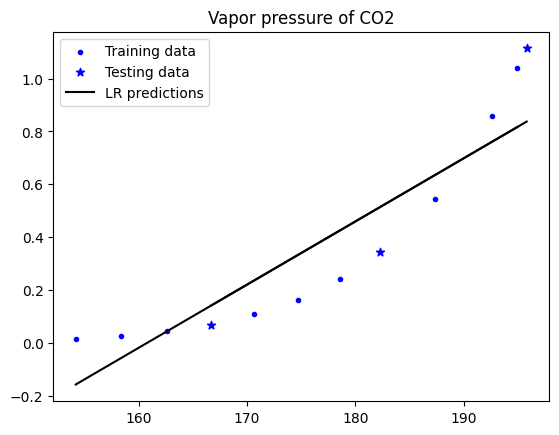

In [ ]:
plt.scatter(expt_data_temp_train, expt_data_press_train, color='blue', marker='.', label='Training data')
plt.scatter(expt_data_temp_val, expt_data_press_val, color='blue', marker='*', label='Testing data')
plt.plot(expt_data_temp_train, lin_reg_press_train_pred,color='black',label='LR predictions')
plt.plot(expt_data_temp_val, lin_reg_press_val_pred,color='black')
plt.title('Vapor pressure of CO2')
plt.legend()

In [ ]:
print('Coefficient of determination for linear model is {:.4f}'.format(r2(lin_reg_press_train_pred, expt_data_press_train)))

Coefficient of determination for linear model is 0.8455


In [ ]:
scaler = StandardScaler()
scaler.fit(expt_data_temp_train)

scale_expt_data_temp_train = scaler.transform(expt_data_temp_train)
scale_expt_data_temp_val = scaler.transform(expt_data_temp_val)

In [ ]:
scale_expt_data_temp_train_ten = torch.tensor(scale_expt_data_temp_train, dtype=torch.float32)
expt_data_press_train_ten = torch.tensor(expt_data_press_train.reshape(-1,1), dtype=torch.float32)

scale_expt_data_temp_val_ten = torch.tensor(scale_expt_data_temp_val, dtype=torch.float32)
expt_data_press_val_ten = torch.tensor(expt_data_press_val.reshape(-1,1), dtype=torch.float32)

In [ ]:
model = nn.Sequential(
    nn.Linear(1, 10),
    nn.ReLU(),
    nn.Linear(10,1)
)

In [ ]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [ ]:
n_epochs=50
batch_size=1
batch_start = torch.arange(0, len(scale_expt_data_temp_train_ten), batch_size)

In [ ]:
best_mse = np.inf
best_weights = None
history = []
train_history = []

MSE: 0.01
RMSE: 0.08


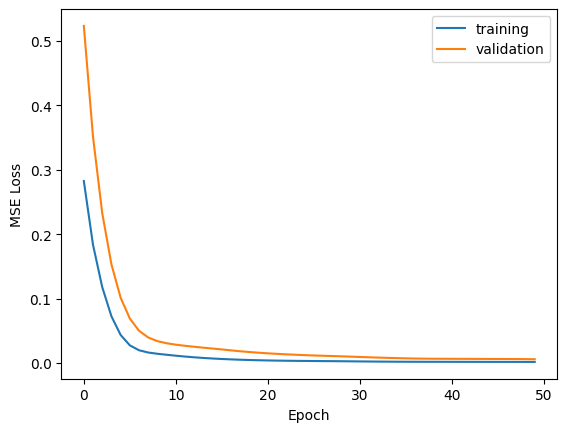

CPU times: user 1.13 s, sys: 55.3 ms, total: 1.18 s
Wall time: 2.08 s


In [ ]:
%%time
for epoch in range(n_epochs):
  model.train()
  with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
    bar.set_description(f"Epoch {epoch}")
    for start in bar:
      X_batch = scale_expt_data_temp_train_ten[start:start+batch_size]
      y_batch = expt_data_press_train_ten[start:start+batch_size]

      y_pred = model(X_batch)
      loss = loss_fn(y_pred, y_batch)

      optimizer.zero_grad()
      loss.backward()

      optimizer.step()

      bar.set_postfix(mse=float(loss))
    model.eval()
    expt_data_press_val_pred = model(scale_expt_data_temp_val_ten)
    mse = loss_fn(expt_data_press_val_pred, expt_data_press_val_ten)
    mse = float(mse)
    history.append(mse)
    expt_data_press_train_pred = model(scale_expt_data_temp_train_ten)
    train_mse = loss_fn(expt_data_press_train_pred, expt_data_press_train_ten)
    train_mse = float(train_mse)
    train_history.append(train_mse)
    if mse < best_mse:
      best_mse = mse
      best_weights = copy.deepcopy(model.state_dict())

model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(train_history,label='training')
plt.plot(history,label='validation')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
expt_data_press_train_pred_ten = model(scale_expt_data_temp_train_ten)
expt_data_press_val_pred_ten = model(scale_expt_data_temp_val_ten)
expt_data_press_train_pred = expt_data_press_train_pred_ten.detach().numpy()
expt_data_press_val_pred = expt_data_press_val_pred_ten.detach().numpy()
expt_data_press_train_pred = expt_data_press_train_pred.reshape(-1)
expt_data_press_val_pred = expt_data_press_val_pred.reshape(-1)

In [ ]:
expt_data_press_train_pred

array([0.01443398, 0.03213373, 0.04977877, 0.08437972, 0.12579745,
       0.25683522, 0.63310546, 0.86342716, 0.9640709 ], dtype=float32)

In [ ]:
print('Coefficient of determination for the ANN is {:.4f}'.format(r2(expt_data_press_train_pred, expt_data_press_train)))

Coefficient of determination for the ANN is 0.9864


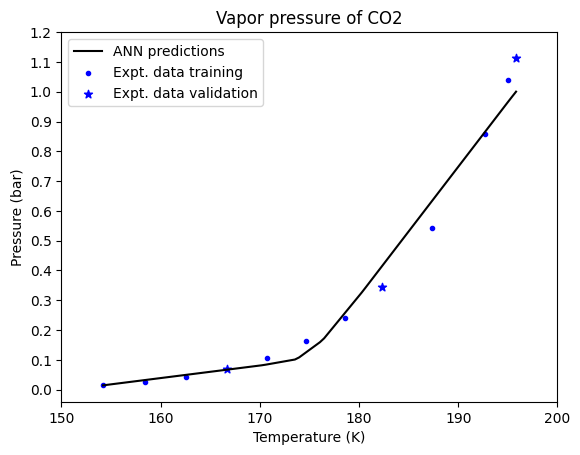

In [ ]:
x = np.linspace(154.196, 195.831, num=100)
x= x.reshape(-1,1)
scale_x = scaler.transform(x)
x_ten =  torch.tensor(scale_x, dtype=torch.float32)
y_ten = model(x_ten)
y = y_ten.detach().numpy()
plt.plot(x,y,color='black',label='ANN predictions')
plt.scatter(expt_data_temp_train, expt_data_press_train, marker='.',color='blue', label='Expt. data training')
plt.scatter(expt_data_temp_val, expt_data_press_val, marker='*', color='blue',label='Expt. data validation')
plt.xticks([150,160,170,180,190,200])
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2])
plt.xlabel('Temperature (K)')
plt.ylabel('Pressure (bar)')
plt.title('Vapor pressure of CO2')
plt.legend()

In [ ]:
new_expt_data_temp = np.array([217.113,	217.654,	218.252,	218.87,	220.655,
                               227.282,	233.911,	241.648,	246.905,	251.974,
                               253.907,	260.79,	267.746,	271.473,	272.379,
                               273.165,	274.186,	275.171,	276.165])
new_expt_data_press = np.array([5.303249175,	5.42879085,	5.568315375,	5.71776975,	6.163093125,
                                8.046116925,	10.33211025,	13.569444,	16.1613375,	18.9903315,
                                20.15860875,	24.747618,	30.1198695,	33.32477925,	34.1404455,
                                34.8558,	35.81332125,	36.748551,	37.7151915])

In [ ]:
new_expt_data_temp = new_expt_data_temp.reshape(-1,1)
scale_new_expt_data_temp = scaler.transform(new_expt_data_temp)
scale_new_expt_data_temp_ten = torch.tensor(scale_new_expt_data_temp, dtype=torch.float32)
new_expt_data_press_pred_ten = model(scale_new_expt_data_temp_ten)
new_expt_data_press_pred = new_expt_data_press_pred_ten.detach().numpy()

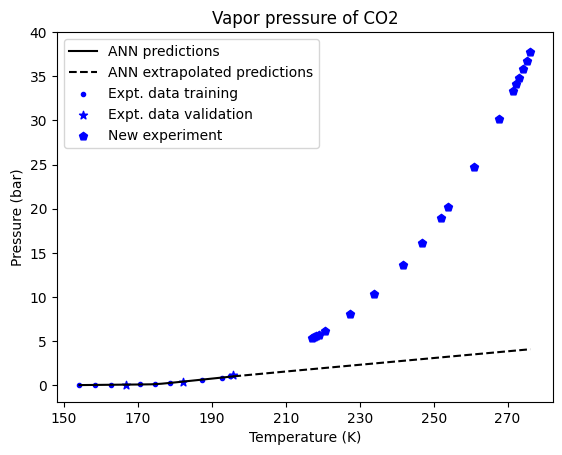

In [ ]:
x = np.linspace(154.196, 195.831, num=100)
x= x.reshape(-1,1)
x_ext = np.linspace(195.832, 276.165, num=100)
x_ext = x_ext.reshape(-1,1)
scale_x = scaler.transform(x)
scale_x_ext = scaler.transform(x_ext)
x_ten =  torch.tensor(scale_x, dtype=torch.float32)
x_ext_ten = torch.tensor(scale_x_ext, dtype=torch.float32)
y_ten = model(x_ten)
y_ext_ten = model(x_ext_ten)
y = y_ten.detach().numpy()
y_ext = y_ext_ten.detach().numpy()
plt.plot(x,y,color='black',label='ANN predictions')
plt.plot(x_ext,y_ext,color='black',linestyle='--',label='ANN extrapolated predictions')
plt.scatter(expt_data_temp_train, expt_data_press_train, marker='.',color='blue', label='Expt. data training')
plt.scatter(expt_data_temp_val, expt_data_press_val, marker='*', color='blue',label='Expt. data validation')
plt.scatter(new_expt_data_temp, new_expt_data_press, marker='p', color='blue', label='New experiment')
plt.xticks([150,170,190,210,230,250,270])
plt.yticks([0,5,10,15,20,25,30,35,40])
plt.xlabel('Temperature (K)')
plt.ylabel('Pressure (bar)')
plt.title('Vapor pressure of CO2')
plt.legend()

In [ ]:
scaled_new_expt_data_temp = scaler.transform(new_expt_data_temp)
scaled_new_expt_data_temp = torch.tensor(scaled_new_expt_data_temp, dtype=torch.float32)
new_expt_data_press_pred = model(scaled_new_expt_data_temp)
new_expt_data_press_pred = new_expt_data_press_pred.detach().numpy()
new_expt_data_press_pred = new_expt_data_press_pred.reshape(-1)

In [ ]:
print('Coefficient of determination on new experimental data for the ANN is {:.4f}'.format(r2(new_expt_data_press_pred, new_expt_data_press)))

Coefficient of determination on new experimental data for the ANN is -1.7965


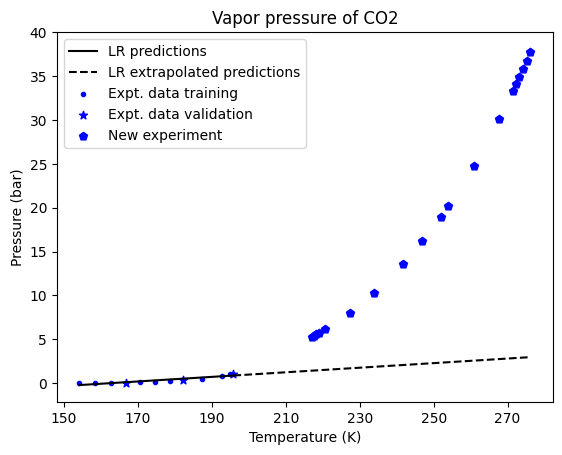

In [ ]:
x = np.linspace(154.196, 195.831, num=100)
x= x.reshape(-1,1)
x_ext = np.linspace(195.832, 276.165, num=100)
x_ext = x_ext.reshape(-1,1)
scale_x = scaler.transform(x)
scale_x_ext = scaler.transform(x_ext)
x_ten =  torch.tensor(scale_x, dtype=torch.float32)
x_ext_ten = torch.tensor(scale_x_ext, dtype=torch.float32)
y_ten = model(x_ten)
y_ext_ten = model(x_ext_ten)
y = y_ten.detach().numpy()
y_ext = y_ext_ten.detach().numpy()
plt.plot([154.196, 195.831],[-0.2044844,0.8821891],color='black',label='LR predictions')
plt.plot([195.832,276.165],[0.8822152,2.9789065],color='black',linestyle='--',label='LR extrapolated predictions')
plt.scatter(expt_data_temp_train, expt_data_press_train, marker='.',color='blue', label='Expt. data training')
plt.scatter(expt_data_temp_val, expt_data_press_val, marker='*', color='blue',label='Expt. data validation')
plt.scatter(new_expt_data_temp, new_expt_data_press, marker='p', color='blue', label='New experiment')
plt.xticks([150,170,190,210,230,250,270])
plt.yticks([0,5,10,15,20,25,30,35,40])
plt.xlabel('Temperature (K)')
plt.ylabel('Pressure (bar)')
plt.title('Vapor pressure of CO2')
plt.legend()

In [ ]:
lin_reg_new_expt_data_press_pred = lin_reg.predict(new_expt_data_temp)

In [ ]:
print('Coefficient of determination on new experimental data for linear regression is {:.4f}'.format(r2(lin_reg_new_expt_data_press_pred, new_expt_data_press)))

Coefficient of determination on new experimental data for linear regression is -2.0584


In [ ]:
expt_data_invtemp_train = 1/expt_data_temp_train
expt_data_invtemp_val = 1/expt_data_temp_val
expt_data_lnpress_train = np.log(expt_data_press_train)
expt_data_lnpress_val = np.log(expt_data_press_val)

In [ ]:
phy_scaler = StandardScaler()
phy_scaler.fit(expt_data_invtemp_train)

scale_expt_data_invtemp_train = phy_scaler.transform(expt_data_invtemp_train)
scale_expt_data_invtemp_val = phy_scaler.transform(expt_data_invtemp_val)

In [ ]:
scale_expt_data_invtemp_train_ten = torch.tensor(scale_expt_data_invtemp_train, dtype=torch.float32)
expt_data_lnpress_train_ten = torch.tensor(expt_data_lnpress_train.reshape(-1,1), dtype=torch.float32)

scale_expt_data_invtemp_val_ten = torch.tensor(scale_expt_data_invtemp_val, dtype=torch.float32)
expt_data_lnpress_val_ten = torch.tensor(expt_data_lnpress_val.reshape(-1,1), dtype=torch.float32)

In [ ]:
phy_model = nn.Sequential(
    nn.Linear(1, 10),
    nn.ReLU(),
    nn.Linear(10,1)
)

In [ ]:
loss_fn = nn.MSELoss()
phy_optimizer = optim.Adam(phy_model.parameters(), lr=0.005)

In [ ]:
phy_n_epochs=50
phy_batch_size=1
phy_batch_start = torch.arange(0, len(scale_expt_data_invtemp_train_ten), phy_batch_size)

In [ ]:
phy_best_mse = np.inf
phy_best_weights = None
phy_history = []
phy_train_history = []

MSE: 0.02
RMSE: 0.14


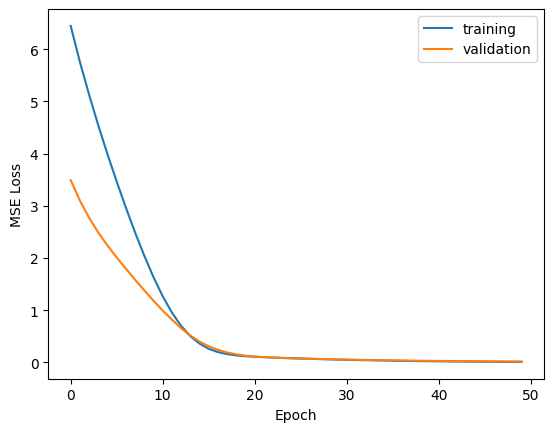

CPU times: user 1.31 s, sys: 40.6 ms, total: 1.35 s
Wall time: 4.35 s


In [ ]:
%%time
for epoch in range(phy_n_epochs):
  phy_model.train()
  with tqdm.tqdm(phy_batch_start, unit="batch", mininterval=0, disable=True) as bar:
    bar.set_description(f"Epoch {epoch}")
    for start in bar:
      X_batch = scale_expt_data_invtemp_train_ten[start:start+phy_batch_size]
      y_batch = expt_data_lnpress_train_ten[start:start+phy_batch_size]

      y_pred = phy_model(X_batch)
      phy_loss = loss_fn(y_pred, y_batch)

      phy_optimizer.zero_grad()
      phy_loss.backward()

      phy_optimizer.step()

      bar.set_postfix(mse=float(phy_loss))
    phy_model.eval()
    expt_data_lnpress_val_pred = phy_model(scale_expt_data_invtemp_val_ten)
    mse = loss_fn(expt_data_lnpress_val_pred, expt_data_lnpress_val_ten)
    mse = float(mse)
    phy_history.append(mse)
    expt_data_lnpress_train_pred = phy_model(scale_expt_data_invtemp_train_ten)
    train_mse = loss_fn(expt_data_lnpress_train_pred, expt_data_lnpress_train_ten)
    train_mse = float(train_mse)
    phy_train_history.append(train_mse)
    if mse < phy_best_mse:
      phy_best_mse = mse
      phy_best_weights = copy.deepcopy(phy_model.state_dict())

phy_model.load_state_dict(phy_best_weights)
print("MSE: %.2f" % phy_best_mse)
print("RMSE: %.2f" % np.sqrt(phy_best_mse))
plt.plot(phy_train_history,label='training')
plt.plot(phy_history,label='validation')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
expt_data_lnpress_train_pred_ten = phy_model(scale_expt_data_invtemp_train_ten)
expt_data_lnpress_val_pred_ten = phy_model(scale_expt_data_invtemp_val_ten)
expt_data_lnpress_train_pred = expt_data_lnpress_train_pred_ten.detach().numpy()
expt_data_lnpress_val_pred = expt_data_lnpress_val_pred_ten.detach().numpy()
expt_data_lnpress_train_pred = expt_data_lnpress_train_pred.reshape(-1)
expt_data_lnpress_val_pred = expt_data_lnpress_val_pred.reshape(-1)

In [ ]:
print('Coefficient of determination for feature-engineered ANN is {:.4f}'.format(r2(expt_data_lnpress_train_pred, expt_data_lnpress_train)))

Coefficient of determination for feature-engineered ANN is 0.9950


In [ ]:
new_expt_data_invtemp = 1/new_expt_data_temp
new_expt_data_lnpress = np.log(new_expt_data_press)

In [ ]:
new_expt_data_temp_ten = torch.tensor(new_expt_data_temp.reshape(-1,1), dtype=torch.float32)
new_expt_data_press_pred_ten = model(new_expt_data_temp_ten)
new_expt_data_press_pred = new_expt_data_press_pred_ten.detach().numpy()

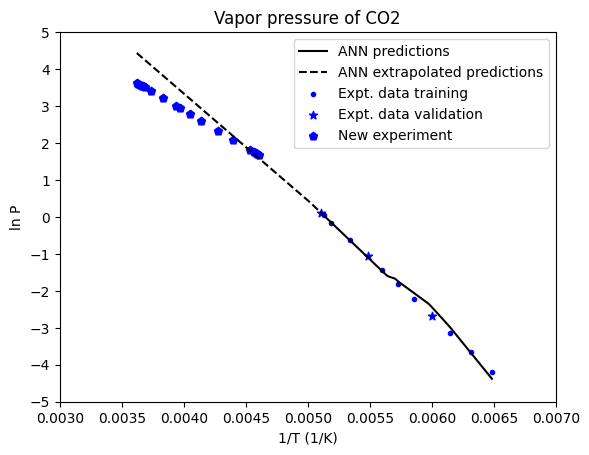

In [ ]:
x = np.linspace(1/195.831, 1/154.196, num=100)
x= x.reshape(-1,1)
x_ext = np.linspace(1/276.165, 1/195.832, num=100)
x_ext = x_ext.reshape(-1,1)
scale_x = phy_scaler.transform(x)
scale_x_ext = phy_scaler.transform(x_ext)
x_ten =  torch.tensor(scale_x, dtype=torch.float32)
x_ext_ten = torch.tensor(scale_x_ext, dtype=torch.float32)
y_ten = phy_model(x_ten)
y_ext_ten = phy_model(x_ext_ten)
y = y_ten.detach().numpy()
y_ext = y_ext_ten.detach().numpy()
plt.plot(x,y,color='black',label='ANN predictions')
plt.plot(x_ext,y_ext,color='black',linestyle='--',label='ANN extrapolated predictions')
plt.scatter(expt_data_invtemp_train, expt_data_lnpress_train, marker='.',color='blue', label='Expt. data training')
plt.scatter(expt_data_invtemp_val, expt_data_lnpress_val, marker='*', color='blue',label='Expt. data validation')
plt.scatter(new_expt_data_invtemp, new_expt_data_lnpress, marker='p', color='blue', label='New experiment')
plt.xticks([0.003,.0035,.004,.0045,.005,.0055,.006,.0065,.007])
plt.yticks([-5,-4,-3,-2,-1,0,1,2,3,4,5])
plt.xlabel('1/T (1/K)')
plt.ylabel('ln P')
plt.title('Vapor pressure of CO2')
plt.legend()

In [ ]:
scaled_new_expt_data_invtemp = phy_scaler.transform(new_expt_data_invtemp)
scaled_new_expt_data_invtemp = torch.tensor(scaled_new_expt_data_invtemp, dtype=torch.float32)
new_expt_data_lnpress_pred = phy_model(scaled_new_expt_data_invtemp)
new_expt_data_lnpress_pred = new_expt_data_lnpress_pred.detach().numpy()
new_expt_data_lnpress_pred = new_expt_data_lnpress_pred.reshape(-1)

In [ ]:
print('Coefficient of determination on new experimental data for feature engineered ANN is {:.4f}'.format(r2(new_expt_data_lnpress_pred, new_expt_data_lnpress)))

Coefficient of determination on new experimental data for feature engineered ANN is 0.5001
